In [1]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split

from torchvision import datasets, transforms

from get_dataset import X
from get_dataset import y

#% matplotlib inline
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 1234

In [2]:
# hyper parameters
LEARNING_RATE = 0.01
BATCH_SIZE = 64
N_EPOCHS = 30
N_CLASSES = 2

In [3]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
def train(train_loader, model, criterion, optimizer):
    '''
    Train the model for one epoch and return loss & accuracy.
    '''
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for X, y_true in train_loader:
        optimizer.zero_grad()

        # Forward Pass
        y_hat = model(X)
        if isinstance(y_hat, tuple):  
            y_hat = y_hat[0]

        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

        # Backward Pass
        loss.backward()
        optimizer.step()

        # Compute Accuracy
        preds = torch.argmax(y_hat, dim=1)  # Get predicted class
        correct += (preds == y_true).sum().item()
        total += y_true.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total  # Compute accuracy

    return epoch_loss, epoch_acc


In [5]:
def test(test_loader, model, criterion):
    '''
    Evaluate the model on test data and compute loss & accuracy.
    '''
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    
    with torch.no_grad():
        for X, y_true in test_loader:
            y_hat = model(X)
            if isinstance(y_hat, tuple):
                y_hat = y_hat[0]

            loss = criterion(y_hat, y_true)
            running_loss += loss.item() * X.size(0)

            preds = torch.argmax(y_hat, dim=1) 
            correct += (preds == y_true).sum().item()
            total += y_true.size(0)

    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = correct / total 

    return epoch_loss, epoch_acc


In [6]:
def training_loop(model, criterion, optimizer, train_loader, test_loader, epochs, print_every=1, scheduler=None, early_stopper=None):
    '''
    Function defining the entire training loop
    '''
    
    # Correctly initialize lists for storing metrics
    best_loss = float('inf')
    train_losses, test_losses = [], []
    train_accs, test_accs = [], [] 

    for epoch in range(epochs):

        # Training Step
        model.train()
        train_loss, train_acc = train(train_loader, model, criterion, optimizer)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation Step
        test_loss, test_acc = test(test_loader, model, criterion)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        # Print Progress
        if epoch % print_every == (print_every - 1):
            print(f'{datetime.now().time().replace(microsecond=0)} '
                  f'Epoch: {epoch+1}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Test loss: {test_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Test accuracy: {100 * test_acc:.2f}')
        
        # Adjust learning rate if scheduler is provided
        if scheduler:
            scheduler.step(test_acc)  # Reduce LR based on test accuracy
            
        # Early stopping (if enabled)
        if early_stopper and early_stopper.check(test_acc):
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Save Performance Metrics
    performance = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_acc': train_accs,
        'test_acc': test_accs
    }
    
    return model, optimizer, performance



In [7]:
def get_accuracy(model, data_loader):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            _, y_hat = model(X)
            _, predicted_labels = torch.max(y_hat, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n


    
def plot_performance(performance):
    '''
    Function for plotting training and test losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn-v0_8-dark')

    fig, ax = plt.subplots(1, 2, figsize = (16, 4.5))
    for key, value in performance.items():
        if 'loss' in key:
            ax[0].plot(value, label=key) 
        else:
            ax[1].plot(value, label=key) 
    ax[0].set(title="Loss  over epochs", 
            xlabel='Epoch',
            ylabel='Loss')
    ax[1].set(title="accuracy over epochs", 
            xlabel='Epoch',
            ylabel='Loss')
    ax[0].legend()
    ax[1].legend()
    plt.show()
    
    # change the plot style to default
    plt.style.use('default')    

In [8]:
class MLP(nn.Module):
    def __init__(self, layers, dropout_rate=0.1):
        super(MLP, self).__init__()
        modules = []
        for i in range(1, len(layers)):
            modules.append(nn.Linear(layers[i-1], layers[i]))
            if i != len(layers) - 1:  
                modules.append(nn.Sigmoid())
        self.layers = nn.Sequential(*modules)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.layers(x)  # Return raw logits


In [9]:
import torch.optim as optim

torch.manual_seed(seed)
layers = [X_tensor.shape[1], 512, 256, 128, N_CLASSES]  # Adjust if needed

model = MLP(layers)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())


In [10]:
model, optimizer, performance = training_loop(model, criterion, optimizer, train_loader, test_loader, N_EPOCHS)

22:12:18 Epoch: 1	Train loss: 0.2959	Test loss: 0.2845	Train accuracy: 88.47	Test accuracy: 88.64
22:12:19 Epoch: 2	Train loss: 0.2781	Test loss: 0.2819	Train accuracy: 88.55	Test accuracy: 88.79
22:12:20 Epoch: 3	Train loss: 0.2770	Test loss: 0.2773	Train accuracy: 88.51	Test accuracy: 88.34
22:12:21 Epoch: 4	Train loss: 0.2753	Test loss: 0.2810	Train accuracy: 88.68	Test accuracy: 88.63
22:12:22 Epoch: 5	Train loss: 0.2741	Test loss: 0.2819	Train accuracy: 88.63	Test accuracy: 88.39
22:12:24 Epoch: 6	Train loss: 0.2722	Test loss: 0.2757	Train accuracy: 88.78	Test accuracy: 88.85
22:12:25 Epoch: 7	Train loss: 0.2721	Test loss: 0.2860	Train accuracy: 88.86	Test accuracy: 88.58
22:12:26 Epoch: 8	Train loss: 0.2693	Test loss: 0.2685	Train accuracy: 88.82	Test accuracy: 88.69
22:12:27 Epoch: 9	Train loss: 0.2686	Test loss: 0.2706	Train accuracy: 88.76	Test accuracy: 88.79
22:12:28 Epoch: 10	Train loss: 0.2694	Test loss: 0.2739	Train accuracy: 88.84	Test accuracy: 88.74
22:12:29 Epoch: 11	

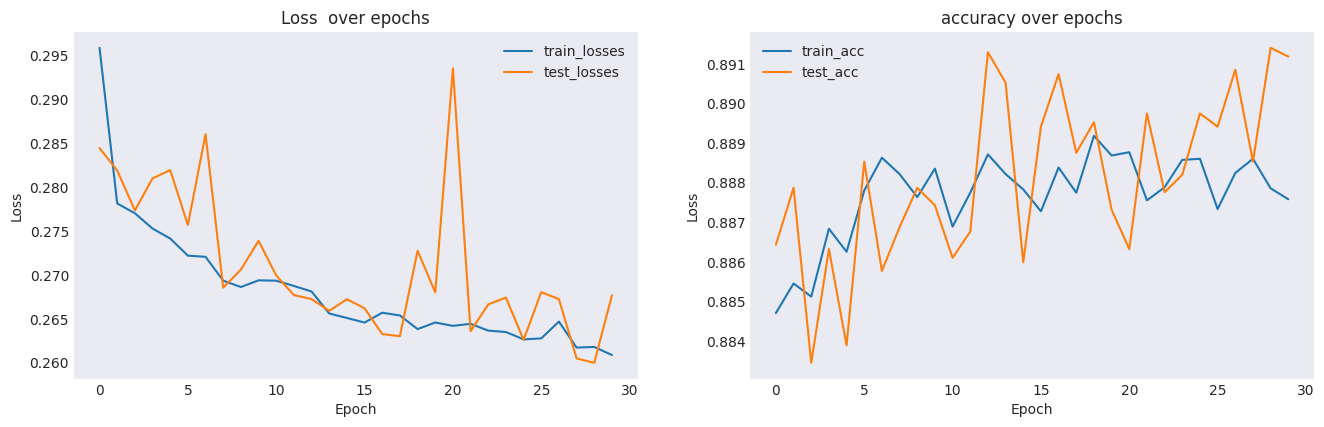

In [11]:
plot_performance(performance)